In [1]:
import sys
sys.path.append("..")


import numpy as np
import random
import csv

from idtrees.utils import read_tifs #, load_data # Import data utils
%matplotlib inline 
import matplotlib.pyplot as plt
from configs import *

## Read and Display One Hyperspectral Image

HSI image shape:  (369, 20, 20)


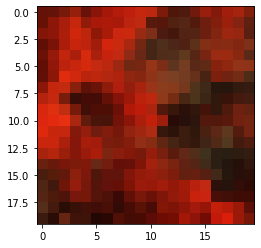

In [2]:
hsi_im_paths = read_tifs.get_im_paths('HSI')
im_id = 29
im = read_tifs.read_tif_to_ndarray(hsi_im_paths[im_id])

print('HSI image shape: ', im.shape)

# Grab a random three band combination
bands = (91,200,360)

# Plot an HSI Image 
im_plt = np.rollaxis(im[bands,:,:],0,start=3)
plt.imshow(im_plt)

## Show first n hyperspectral images 

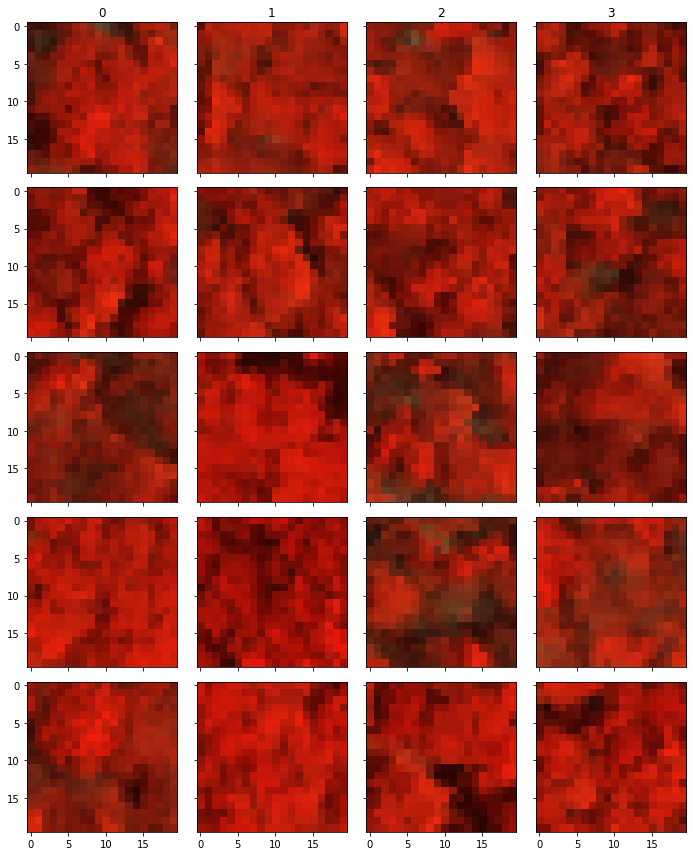

In [3]:
n = 20
ims = read_tifs.read_all_tif_to_ndarray(hsi_im_paths)[:n]
read_tifs.plot_all_ims(ims[:,bands,:,:], title='hsi')

In [4]:
# Read in all HSI images
ims_hsi = read_tifs.read_all_tif_to_ndarray(hsi_im_paths)
print('Total Number of HSI images: ', ims_hsi.shape[0])

Total Number of HSI images:  85


## Plot mean over all hyperspectral pixels in all images

(85, 369, 20, 20)


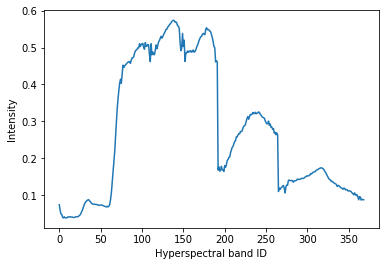

In [5]:
read_tifs.plot_spectral_curve(ims_hsi)

### Extracting ITCs as differently sized HSI images with a Tree Species Label

In [6]:
import torch
from idtrees.utils.dataset import TreeImagesDataset

# Load hsi dataset of bounding boxes with torch dataloader
csv_file ='data/data_train_mitree.csv'
root_dir = repo_path
image_dataset = TreeImagesDataset(csv_file, root_dir, object_rec=False, datatype='hsi', instance_type = 'boxes')
image_dataset = torch.utils.data.Subset(image_dataset, [0]) # TODO: find out what the [0] does

# Get number of bounding boxes in dataset
n_boxes = image_dataset.dataset.__len__()
print('Number of trees, labeled with species and bounding box: ', n_boxes)

Number of trees, labeled with species and bounding box:  1165


In [7]:
im_all = []
class_ids = []
for idx in range(n_boxes): 
    # Get image and target of current bounding box 
    im, target = image_dataset.dataset.__getitem__(idx)
    im_all.append(im)
    class_ids.append(target['labels'])
    
classes = np.unique(class_ids)

print("")
print("Number of HSI bounding boxes images: ", len(im_all))
print("Number of Class ID's: ", len(class_ids))
print("Number of Unique Tree Classes in Data: ", len(classes))


[WARNING] Loaded box has zero shape and is sketchily inflated. TODO: skip this box
[WARNING] Loaded box has zero shape and is sketchily inflated. TODO: skip this box

Number of HSI bounding boxes images:  1165
Number of Class ID's:  1165
Number of Unique Tree Classes in Data:  33


In [8]:
import pandas as pd
df = pd.read_csv(repo_path + 'data/train/Field/taxonID_ScientificName.csv')

class_id_val = []
n_im_val = []
sci_names = []

# Iterate over each class and print class id, number of pixels, and scientific name
print('cls_id \tn_px \tscientific name')
for c in classes:
    ids_in_c = np.where(class_ids == c)[0]
    n_im = len([class_ids[x] for x in ids_in_c])
    sci_name = df[df.taxonCode==c].scientificName.iloc[0]
    class_id_val.append(c)
    n_im_val.append(n_im)
    sci_names.append(sci_name)
    
    print(str(int(c)) +":\t"+ str(n_im) + "\t"+  sci_name)

cls_id 	n_px 	scientific name
1:	8	Acer pensylvanicum L.
2:	139	Acer rubrum L.
3:	1	Acer saccharum Marshall
4:	46	Amelanchier laevis Wiegand
5:	6	Betula sp.
6:	3	Carya glabra (Mill.) Sweet
7:	1	Carya tomentosa (Lam.) Nutt.
8:	6	Fagus grandifolia Ehrh.
9:	1	Gordonia lasianthus (L.) Ellis
10:	17	Liriodendron tulipifera L.
11:	1	Lyonia lucida (Lam.) K. Koch
12:	15	Magnolia sp.
13:	2	Nyssa biflora Walter
14:	45	Nyssa sylvatica Marshall
15:	11	Oxydendrum sp.
16:	2	Persea palustris (Raf.) Sarg.
17:	6	Pinus elliottii Engelm.
18:	367	Pinus palustris Mill.
19:	9	Pinus sp.
20:	4	Pinus taeda L.
21:	7	Prunus serotina Ehrh.
22:	103	Quercus alba L.
23:	53	Quercus coccinea
24:	18	Quercus geminata Small
25:	5	Quercus hemisphaerica W. Bartram ex Willd.
26:	97	Quercus laevis Walter
27:	1	Quercus laurifolia Michx.
28:	12	Quercus montana Willd.
29:	3	Quercus nigra L.
30:	169	Quercus rubra L.
31:	1	Quercus sp.
32:	2	Robinia pseudoacacia L.
33:	4	Tsuga canadensis (L.) Carriere


### We only use the following class_ids
Can't use just the top 4 classes and group everything else into other because you then get a huge class imbalance. Chose ones with over 2000 pixels. 

Use: (2, 18, 22, 23, 26, 30)
Other: All the rest 

In [9]:
keep = np.array([2.,18., 22., 23., 26., 30.])
im_keep = []
im_not_keep = []
new_class_ids = []


for c in keep:
    ids_in_c = np.where(class_ids == c)[0]
    n_im = [im_all[x] for x in ids_in_c]
    for n in n_im:
        im_keep.append(n)
        new_class_ids.append(c)

for c in classes:
    if c not in keep:
        ids_nin_c = np.where(class_ids == c)[0] 
        n_im = [im_all[x] for x in ids_nin_c]
        for n in n_im:
            im_not_keep.append(n)
            new_class_ids.append(34.)

print(len(im_not_keep), len(im_keep))

#combine into new total list, with a 34th class id known as 'Other'
im_all_new = im_keep 
im_all_new.extend(im_not_keep)

new_classes = np.unique(new_class_ids)
print(new_classes)


237 928
[ 2. 18. 22. 23. 26. 30. 34.]


In [10]:
print(len(new_class_ids))
print(len(im_all_new))

1165
1165


In [11]:
df.loc[34, :] = [34., 'OTHER', 'ALL Others']

class_id_val = []
n_im_val = []
sci_names = []

# Iterate over each class and print class id, number of pixels, and scientific name
print('cls_id \tn_px \tscientific name')

for c in new_classes:
    ids_in_c = np.where(new_class_ids == c)[0]
    n_im = len([new_class_ids[x] for x in ids_in_c])
    sci_name = df[df.taxonCode==c].scientificName.iloc[0]
    class_id_val.append(c)
    n_im_val.append(n_im)
    sci_names.append(sci_name)
    
    print(str(int(c)) +":\t"+ str(n_im) + "\t"+  sci_name)
    

cls_id 	n_px 	scientific name
2:	139	Acer rubrum L.
18:	367	Pinus palustris Mill.
22:	103	Quercus alba L.
23:	53	Quercus coccinea
26:	97	Quercus laevis Walter
30:	169	Quercus rubra L.
34:	237	ALL Others


In [12]:
data = read_tifs.get_hsi_pixels()


Number of trees, labeled with species and bounding box:  1165
[WARNING] Loaded box has zero shape and is sketchily inflated. TODO: skip this box
[WARNING] Loaded box has zero shape and is sketchily inflated. TODO: skip this box


In [13]:
class_id_val = []
n_px_val = []
sci_names = []
special_val_px = []

class_id_vals = np.unique(data[0,:]) # Class_ids should start with 1

# Iterate over each class and print class id, number of pixels, and scientific name
print('cls_id \tn_px \tscientific name')
for c in class_id_vals:
    if c in keep:
        ids_in_c = np.argwhere([data[0,:] == c])[:,1]
        n_px = data[0,ids_in_c].shape[0]
        sci_name = df[df.taxonCode==c].scientificName.iloc[0]
        class_id_val.append(c)
        n_px_val.append(n_px)
        sci_names.append(sci_name)
        print(str(int(c)) +":\t"+ str(n_px) + "\t"+  sci_name)

    else: 
        ids_in_c = np.argwhere([data[0,:] == c])[:,1]
        n_px = data[0,ids_in_c].shape[0]
        special_val_px.append(n_px)
        
print(str(int(34.)) + ":\t" + str(np.sum(special_val_px)) + "\t" + "ALL OTHER")



cls_id 	n_px 	scientific name
2:	4647	Acer rubrum L.
18:	8700	Pinus palustris Mill.
22:	4392	Quercus alba L.
23:	2066	Quercus coccinea
26:	2073	Quercus laevis Walter
30:	6207	Quercus rubra L.
34:	7403	ALL OTHER


### Convert into Array of Vertically-Stacked Pixels, with first row= Species Class 

In [14]:
spectra = [] # List of spectrum per pixel # TODO write as ndarray
class_id_new = [] # List of target per pixel 

for index in range(len(im_all_new)):
    # Append the spectra and class id of all pixels in bbox to a list
    n_px = np.prod(im_all_new[index].shape[1:])
    spectra.append(im_all_new[index].reshape(-1, n_px))
    class_id_new.append(new_class_ids[index] * np.ones(n_px))

# Convert list into ndarray
spectra = np.concatenate(spectra, axis=1)#.numpy())
class_id_new = np.concatenate(class_id_new, axis=0)

# Add class ids as zero'th row 
pixel_data = np.vstack((class_id_new[np.newaxis,:], spectra))


In [15]:
freq = pd.DataFrame({'class_ids': class_id_val, 'num_pix': n_px_val, 'sci_names': sci_names})
freq.loc[6, :] = ['34.', str(np.sum(special_val_px)), "ALL OTHER"]

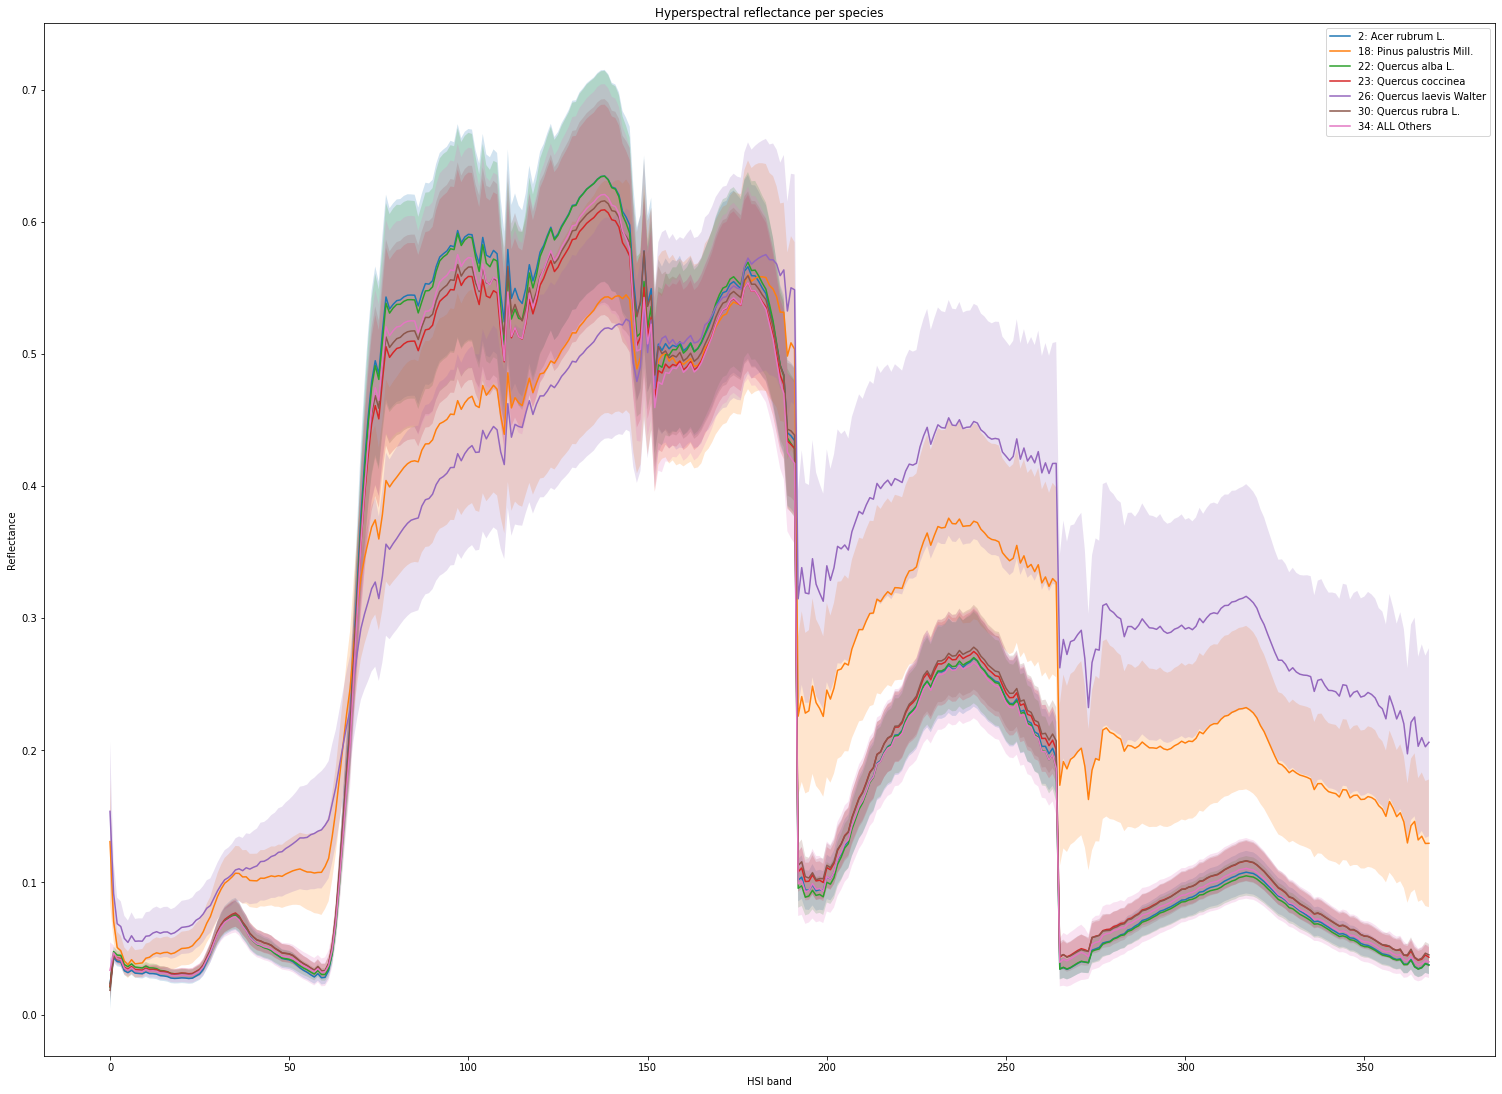

In [16]:
read_tifs.plot_hyperspectral_curve_per_species(pixel_data, new_classes, scale_std = 1/2.)

### Testing baseline scikit-learn classifiers


In [37]:
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets

In [38]:
# Prepare data
n_train = int(.8 * pixel_data.shape[1])
xy = np.rollaxis(pixel_data, 1) # Format X into (n_samples, n_features)
np.random.shuffle(xy) # Shuffle randomly along axis of n_samples 
X = xy[:, 1:] 
Y = xy[:, 0]

In [39]:
# Do PCA
do_pca = True
if do_pca:
    pca = PCA(n_components='mle', whiten=False, svd_solver='full')
    X = pca.fit_transform(X)
print('Shape after [PCA]', X.shape)

Shape after [PCA] (35488, 360)


In [40]:
X_train = X[:n_train, :]
y_train = Y[:n_train]
X_test = X[n_train:, :]
y_test = Y[n_train:]

#### Everything below is from : https://towardsdatascience.com/multiclass-classification-with-support-vector-machines-svm-kernel-trick-kernel-functions-f9d5377d6f02

In [27]:
linear = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo').fit(X_train, y_train)
rbf = svm.SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo').fit(X_train, y_train)
poly = svm.SVC(kernel='poly', degree=3, C=1, decision_function_shape='ovo').fit(X_train, y_train)
sig = svm.SVC(kernel='sigmoid', C=1, decision_function_shape='ovo').fit(X_train, y_train)

In [35]:
linear_pred = linear.predict(X_test)
poly_pred = poly.predict(X_test)
rbf_pred = rbf.predict(X_test)
sig_pred = sig.predict(X_test)

# retrieve the accuracy and print it for all 4 kernel functions
accuracy_lin = linear.score(X_test, y_test)
accuracy_poly = poly.score(X_test, y_test)
accuracy_rbf = rbf.score(X_test, y_test)
accuracy_sig = sig.score(X_test, y_test)

print("Accuracy Linear Kernel:", accuracy_lin)
print("Accuracy Polynomial Kernel:", accuracy_poly)
print('Accuracy Radial Basis Kernel:', accuracy_rbf)
print('Accuracy Sigmoid Kernel:', accuracy_sig)
      
# creating a confusion matrix
cm_lin = confusion_matrix(y_test, linear_pred)
cm_poly = confusion_matrix(y_test, poly_pred)
cm_rbf = confusion_matrix(y_test, rbf_pred)
cm_sig = confusion_matrix(y_test, sig_pred)
      
print(cm_lin)
print(cm_poly)
print(cm_rbf)
print(cm_sig)

Accuracy Linear Kernel: 0.610312764158918
Accuracy Polynomial Kernel: 0.4976049591434207
Accuracy Radial Basis Kernel: 0.6022823330515639
Accuracy Sigmoid Kernel: 0.29092702169625245
[[ 371    3   15    0    0  312  244]
 [   0 1729    0    0   32    0   15]
 [  71    0  281    0    0  316  174]
 [  41    0    5    0    0  240  111]
 [   0  182    0    0  248    0    7]
 [  68    0   28    0    0  956  195]
 [ 133   43   83    0   12  436  747]]
[[  63    1    3    0    0  610  268]
 [   0 1497    0    0   21  221   37]
 [  21    0   86    0    0  429  306]
 [   5    2    3    0    0  304   83]
 [   0  224    0    0  159   45    9]
 [  18    8    3    0    0 1018  200]
 [  22   52   22    0    0  649  709]]
[[ 364    3   22    1    0  290  265]
 [   0 1726    0    0   30    1   19]
 [  79    2  260    1    0  276  224]
 [  55    2   23    4    0  215   98]
 [   0  213    0    0  216    2    6]
 [  81    3   43    2    0  906  212]
 [ 160   54   86    0    3  352  799]]
[[ 381  232    0